# GD2T2D: Model Building

In this notebook we will:
- Create the validation framework
- Test models
- Fine tune the models
- Find the best model

In [1]:
# Imports
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "../data/processed/decoded_data.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

In [5]:
df = df.drop(columns=['perinatal_outcome_28_day_mortality', 'stillbirth_miscarriage'])

In [86]:
df.columns

Index(['older_maternal_age', 'high_pre_pregnancy_bmi_or_overweight',
       'family_history_of_diabetes',
       'socioeconomic_factors_deprivation_quintile',
       'presence_of_t2dm_associated_gene_variants', 'ethnicity', 'multiparity',
       'insulin_treatment_during_pregnancy',
       'pregnancy_complications_hypertensive_disorders',
       'pregnancy_complications_preterm_delivery',
       'pregnancy_complications_pph', 'gestational_weight_gain',
       'abnormal_ogtt_results', 'elevated_hba1c_during_pregnancy',
       'large_for_gestational_age',
       'macrosomia_baby_birth_weightdelivered_a_baby_greater_than_3_5kg',
       'instrumental_delivery', 'nicu_admission',
       'obesity_or_unhealthy_postpartum_weight_gain', 'physical_inactivity',
       'unhealthy_diet', 'smoking', 'alcohol_intake',
       'does_not_undergo_postpartum_glucose_screening', 'breastfeeding',
       'history_of_recurrence_of_gdm', 't2dm_risk'],
      dtype='object')

Dropping columns not needed:
- perinatal_outcome_28_day_mortality      
- stillbirth_miscarriage                                                                


## Creating the validation framework

In [7]:
from sklearn.model_selection import train_test_split

In [8]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [9]:
df_full_train.reset_index(drop=True)

,older_maternal_age,high_pre_pregnancy_bmi_or_overweight,family_history_of_diabetes,socioeconomic_factors_deprivation_quintile,presence_of_t2dm_associated_gene_variants,ethnicity,multiparity,insulin_treatment_during_pregnancy,pregnancy_complications_hypertensive_disorders,pregnancy_complications_preterm_delivery,...,nicu_admission,obesity_or_unhealthy_postpartum_weight_gain,physical_inactivity,unhealthy_diet,smoking,alcohol_intake,does_not_undergo_postpartum_glucose_screening,breastfeeding,history_of_recurrence_of_gdm,t2dm_risk
0,no,yes,no,1,no,asian,yes,yes,yes,yes,...,yes,yes,yes,no,no,no,yes,no,no,1
1,yes,yes,no,3,no,asian,no,yes,yes,no,...,no,yes,yes,no,no,yes,yes,no,no,0
2,no,yes,no,5,no,white,no,yes,yes,no,...,no,no,yes,no,yes,yes,no,no,no,1
3,no,yes,no,3,no,black,no,no,no,no,...,no,yes,yes,no,no,yes,no,yes,no,0
4,no,no,no,3,no,white,no,no,no,no,...,no,no,no,no,no,yes,no,no,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,yes,no,no,3,no,other,no,no,no,no,...,no,yes,yes,yes,no,no,yes,yes,no,0
4796,no,no,no,2,no,asian,yes,no,no,no,...,no,yes,no,no,no,yes,no,yes,no,0
4797,yes,yes,no,4,no,mixed,yes,yes,yes,yes,...,yes,yes,yes,yes,no,no,no,yes,yes,1
4798,no,yes,yes,2,no,white,yes,no,yes,yes,...,no,yes,yes,yes,no,yes,no,no,no,1


In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train.t2dm_risk.values
y_val = df_val.t2dm_risk.values
y_test = df_test.t2dm_risk.values

In [12]:
del df_train['t2dm_risk']
del df_val['t2dm_risk']
del df_test['t2dm_risk']

## Initial Model Training

In this section we will train the following models on the `df_train` data and validate using the validation data. The following models will be tested:
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier



In [13]:
## imports model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.feature_extraction import DictVectorizer

## Metrics imports
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score



### Decision Tree Classifier

In [14]:
# Create dictionaries for the feature matrix
train_dicts = df_train.to_dict(orient='records')

# Then vectorise those dictionaries
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

#Instantiate the decisiontree classifier and train it
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


y_pred = dt.predict_proba(X_val)[:, 1]

scores = []
model = "decision_tree"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
scores.append((model, auc, f1, acc, prec, rec))


In [15]:
columns = ['model', 'auc', 'f1', 'acc', 'prec', 'rec']
df_scores = pd.DataFrame(scores, columns=columns)

In [16]:
df_scores

,model,auc,f1,acc,prec,rec
0,decision_tree,0.794463,0.687603,0.8425,0.679739,0.695652


### Random Forest Classifer

In [17]:
# Create dictionaries for the feature matrix
train_dicts = df_train.to_dict(orient='records')

# Then vectorise those dictionaries
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

#Instantiate the decisiontree classifier and train it
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


y_pred = rf.predict_proba(X_val)[:, 1]

scores = []
model = "random_forest"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
scores.append((model, auc, f1, acc, prec, rec))
df_scores.loc[len(df_scores)] = scores[0]



In [18]:
df_scores

,model,auc,f1,acc,prec,rec
0,decision_tree,0.794463,0.687603,0.842500,0.679739,0.695652
1,random_forest,0.907990,0.734899,0.868333,0.737374,0.732441


### XGBoost 

In [19]:
features = list(dv.get_feature_names_out())

features

['abnormal_ogtt_results=abnormal',
 'abnormal_ogtt_results=normal',
 'alcohol_intake=no',
 'alcohol_intake=yes',
 'breastfeeding=no',
 'breastfeeding=yes',
 'does_not_undergo_postpartum_glucose_screening=no',
 'does_not_undergo_postpartum_glucose_screening=yes',
 'elevated_hba1c_during_pregnancy=elevated',
 'elevated_hba1c_during_pregnancy=normal',
 'ethnicity=asian',
 'ethnicity=black',
 'ethnicity=mixed',
 'ethnicity=other',
 'ethnicity=white',
 'family_history_of_diabetes=no',
 'family_history_of_diabetes=yes',
 'gestational_weight_gain=no',
 'gestational_weight_gain=yes',
 'high_pre_pregnancy_bmi_or_overweight=no',
 'high_pre_pregnancy_bmi_or_overweight=yes',
 'history_of_recurrence_of_gdm=no',
 'history_of_recurrence_of_gdm=yes',
 'instrumental_delivery=no',
 'instrumental_delivery=yes',
 'insulin_treatment_during_pregnancy=no',
 'insulin_treatment_during_pregnancy=yes',
 'large_for_gestational_age=no',
 'large_for_gestational_age=yes',
 'macrosomia_baby_birth_weightdelivered_a_ba

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [21]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

y_pred = model.predict(dval)

scores = []
model = "XGBoost"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
scores.append((model, auc, f1, acc, prec, rec))
df_scores.loc[len(df_scores)] = scores[0]



In [22]:
df_scores

,model,auc,f1,acc,prec,rec
0,decision_tree,0.794463,0.687603,0.842500,0.679739,0.695652
1,random_forest,0.907990,0.734899,0.868333,0.737374,0.732441
2,XGBoost,0.923598,0.731293,0.868333,0.743945,0.719064


Without any model tuning, decision tree performance is not close to the other two models in ROC AUC score. Out of the box, both random forest and XGboost perform well. Next steps will be to tune the models to see the impact this has on performance.

## Model Parameter Tuning

### Decision Tree Parameter Tuning

In this subsection we will finetune the following decision tree paramters:
- max_depth
- min_samples
- 

Performance will be measure with AUC 

In [23]:
dt_scores = []

depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_samples = [1, 5, 10, 15, 20, 500, 100, 200]

for depth in depths:
    for ms in min_samples:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=ms)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred >= 0.5)
        acc = accuracy_score(y_val, y_pred >= 0.5)
        prec = precision_score(y_val, y_pred >= 0.5)
        rec = recall_score(y_val, y_pred >= 0.5)

        dt_scores.append((depth, ms, auc, f1, acc, prec, rec))

columns = ['max_depth', 'min_samples_leaf', 'auc', 'f1', 'acc', 'prec', 'rec']
df_dt_ft_scores = pd.DataFrame(dt_scores, columns=columns)

In [24]:
df_dt_ft_scores

,max_depth,min_samples_leaf,auc,f1,acc,prec,rec
0,1.0,1,0.847568,0.742515,0.856667,0.672087,0.829431
1,1.0,5,0.847568,0.742515,0.856667,0.672087,0.829431
2,1.0,10,0.847568,0.742515,0.856667,0.672087,0.829431
3,1.0,15,0.847568,0.742515,0.856667,0.672087,0.829431
4,1.0,20,0.847568,0.742515,0.856667,0.672087,0.829431
...,...,...,...,...,...,...,...
75,NaN,15,0.917390,0.753333,0.876667,0.750831,0.755853
76,NaN,20,0.917411,0.758278,0.878333,0.750820,0.765886
77,NaN,500,0.918908,0.742515,0.856667,0.672087,0.829431
78,NaN,100,0.940197,0.748252,0.880000,0.783883,0.715719


In [25]:
df_dt_ft_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc,f1,acc,prec,rec
38,5.0,100,0.940235,0.748252,0.88,0.783883,0.715719
54,10.0,100,0.940197,0.748252,0.88,0.783883,0.715719
78,NaN,100,0.940197,0.748252,0.88,0.783883,0.715719
62,15.0,100,0.940197,0.748252,0.88,0.783883,0.715719
46,6.0,100,0.940197,0.748252,0.88,0.783883,0.715719


In [26]:
# Create pivot tables to evaluate best parameters per evaluation metric

pivot_tables = {}

metrics = ['auc', 'f1', 'acc', 'prec', 'rec']

for metric in metrics:
    pivot_tables[f"dt_{metric}_pivot"] = df_dt_ft_scores.pivot(index='min_samples_leaf', columns='max_depth', values=[metric])
    pivot_tables[f"dt_{metric}_pivot"] = pivot_tables[f"dt_{metric}_pivot"].round(3)
    


In [27]:
def plot_dt_ft_eval(pivot_table: pd.DataFrame, metric:str):
    """
    Plot a heatmap visualizing the relationship between `max_depth` and 
    `min_samples_leaf` for a given evaluation metric in a decision tree model.

    Parameters
    ----------
    pivot_table : pd.DataFrame
        A pivot-table–formatted DataFrame where rows represent 
        `min_samples_leaf`, columns represent `max_depth`, and cell values 
        correspond to the chosen evaluation metric.
    metric : str
        The name of the evaluation metric being visualized 
        (e.g., "accuracy", "f1", "auc").
    """
    

    cmap = [
    '#0E7C7BFF',  # original deep teal
    '#139A99FF',  # smoother transition teal → aqua
    '#17BEBBFF',  # original aqua
    '#7FD9CFFF',  # added soft aqua → mint
    '#D4F4DDFF',  # original mint
    '#E8CBD4FF',  # added mint → soft pink transition
    '#D97389FF',  # added mid pink
    '#D62246FF',  # original vivid pink/red
    '#73233AFF',  # added warm burgundy transition
    '#4B1D3FFF'   # original deep wine
]
    plt.figure(figsize=(15,15))
    sns.heatmap(pivot_table, annot=True, cmap=cmap, fmt=".3f")
    plt.title(f"Heatmap of max_depth vs min_samples_leaf for {metric}")
    plt.xlabel("max_depth")
    plt.ylabel("min_samples_leaf")


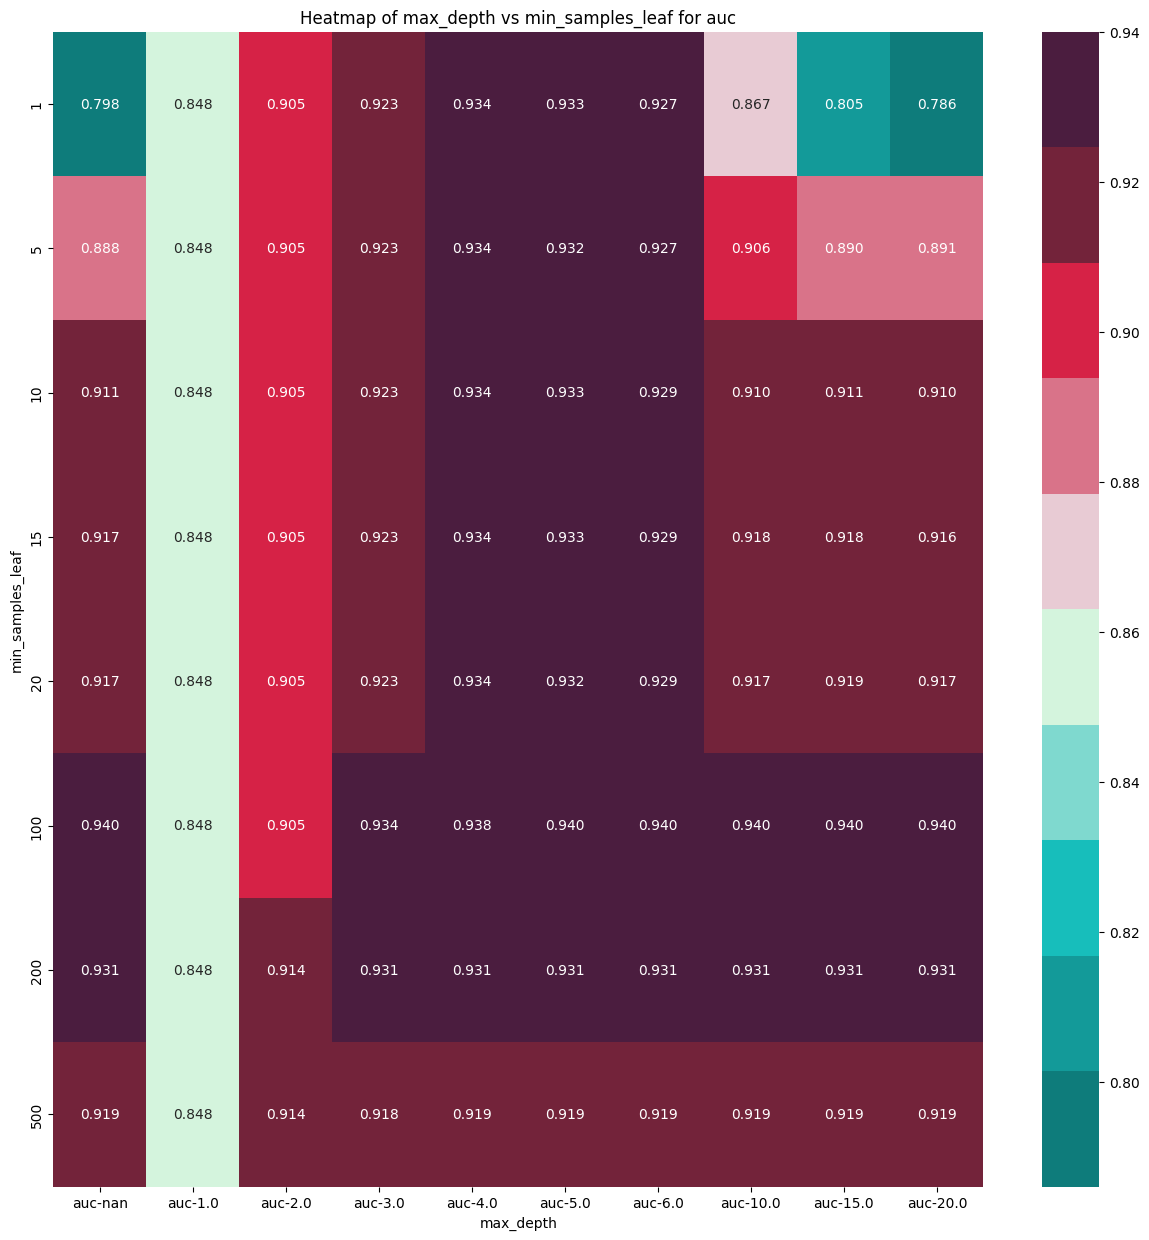

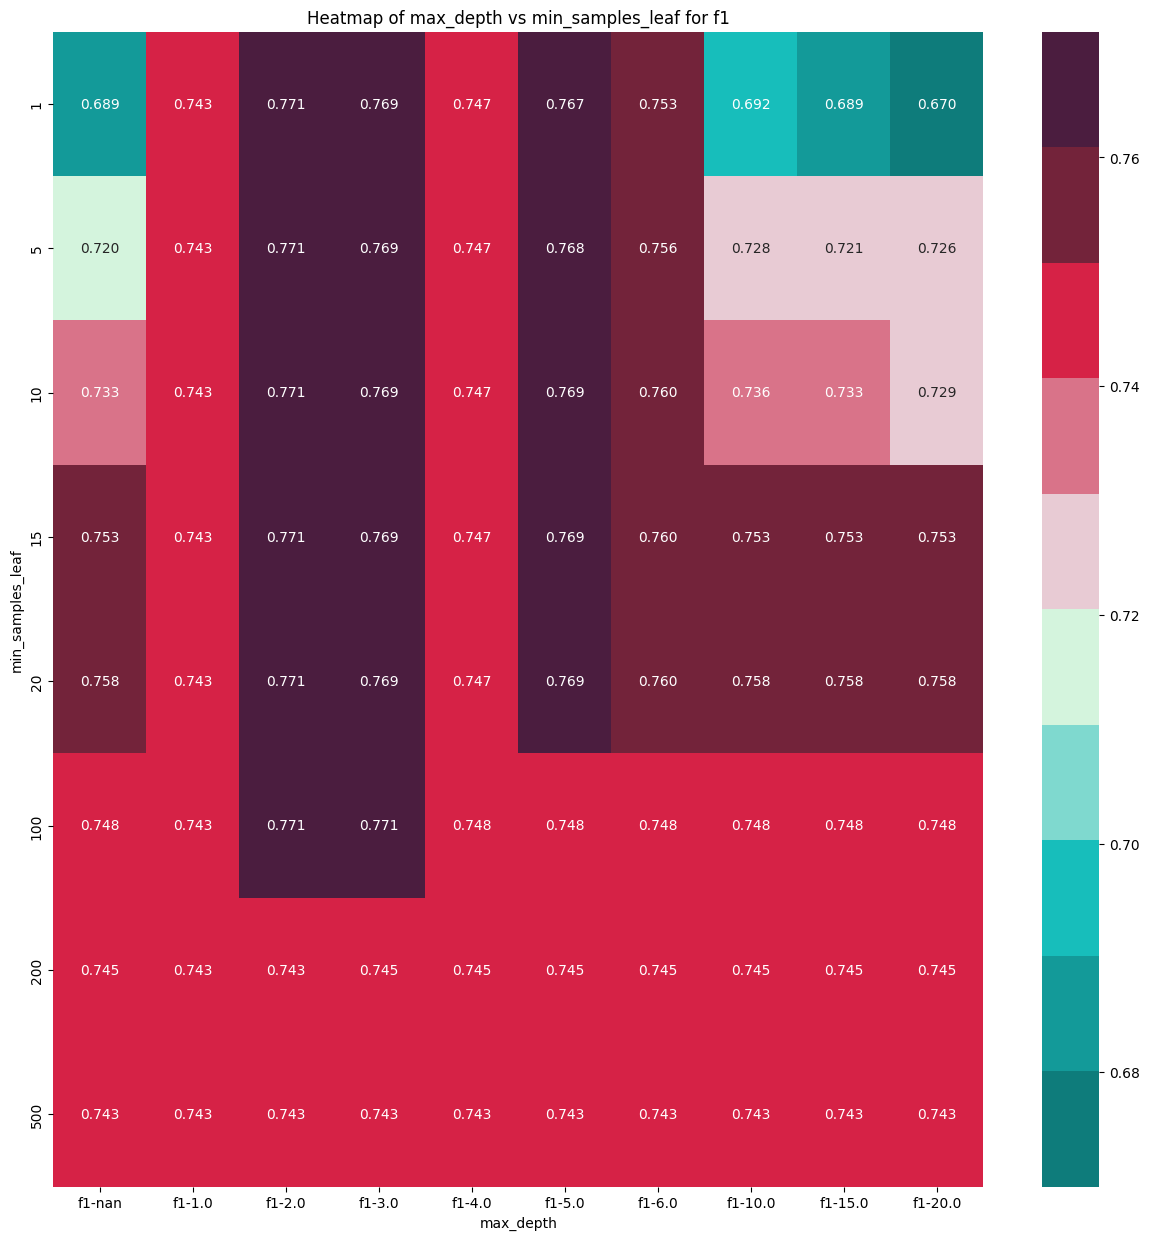

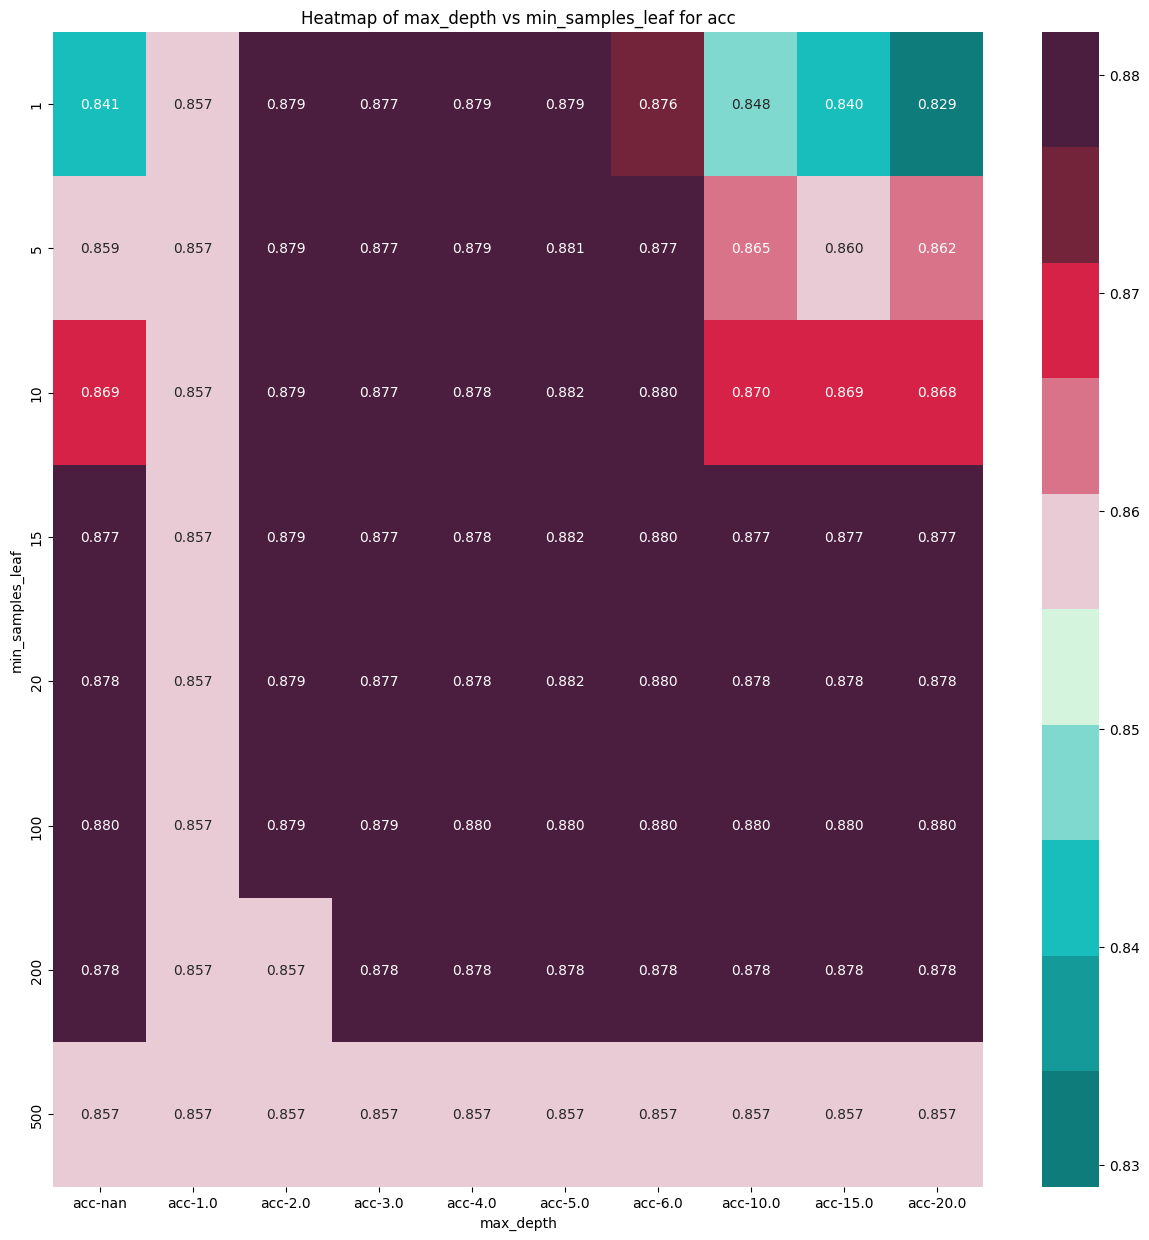

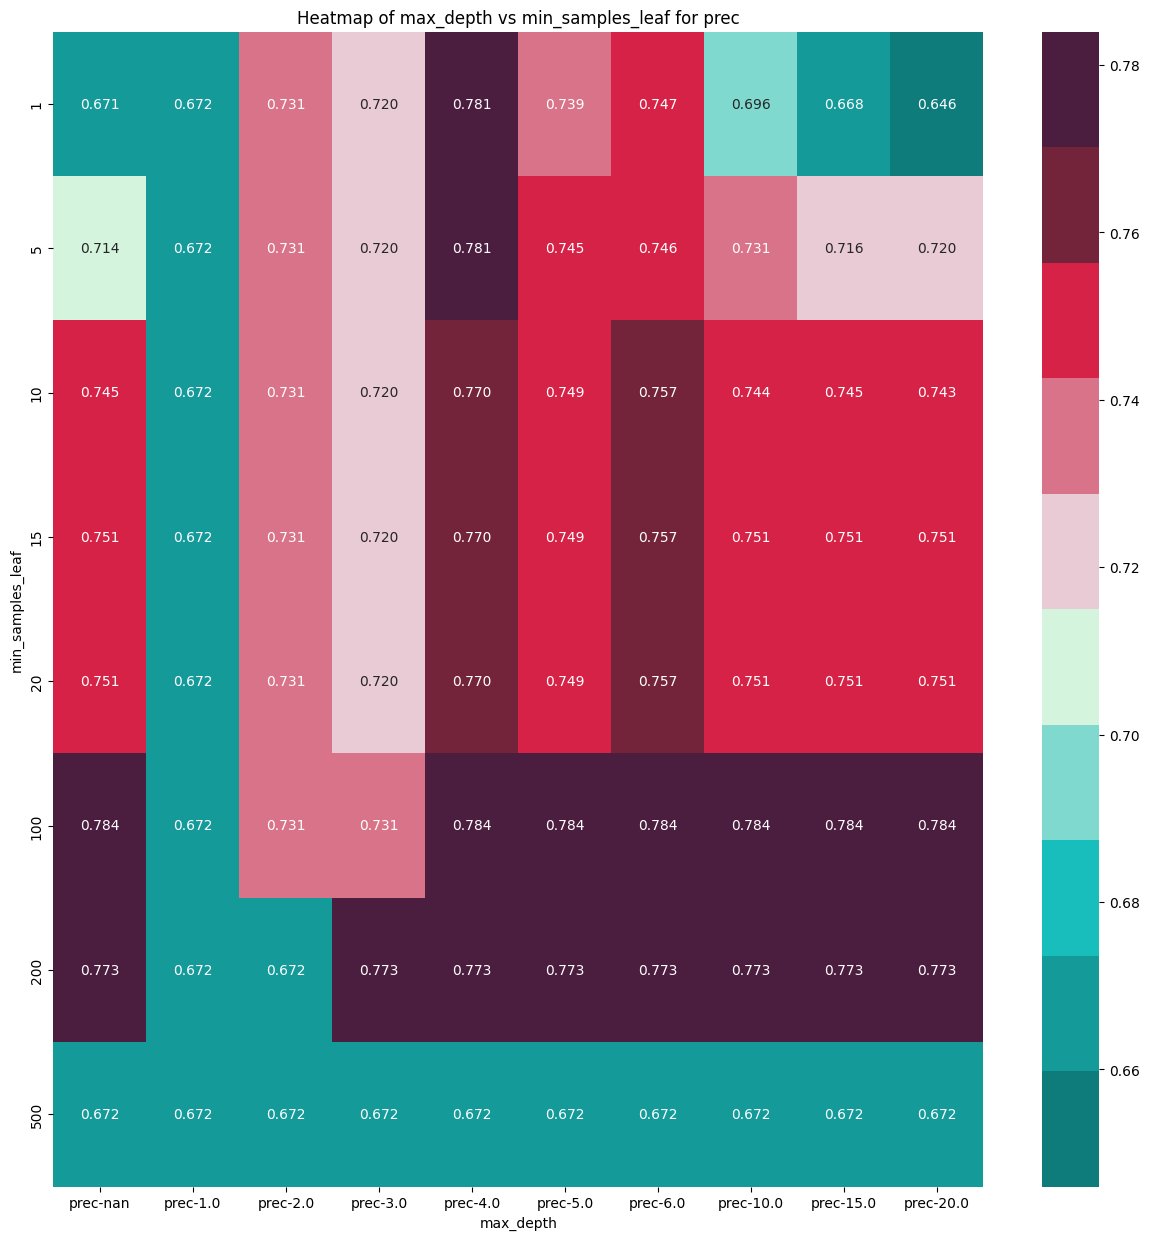

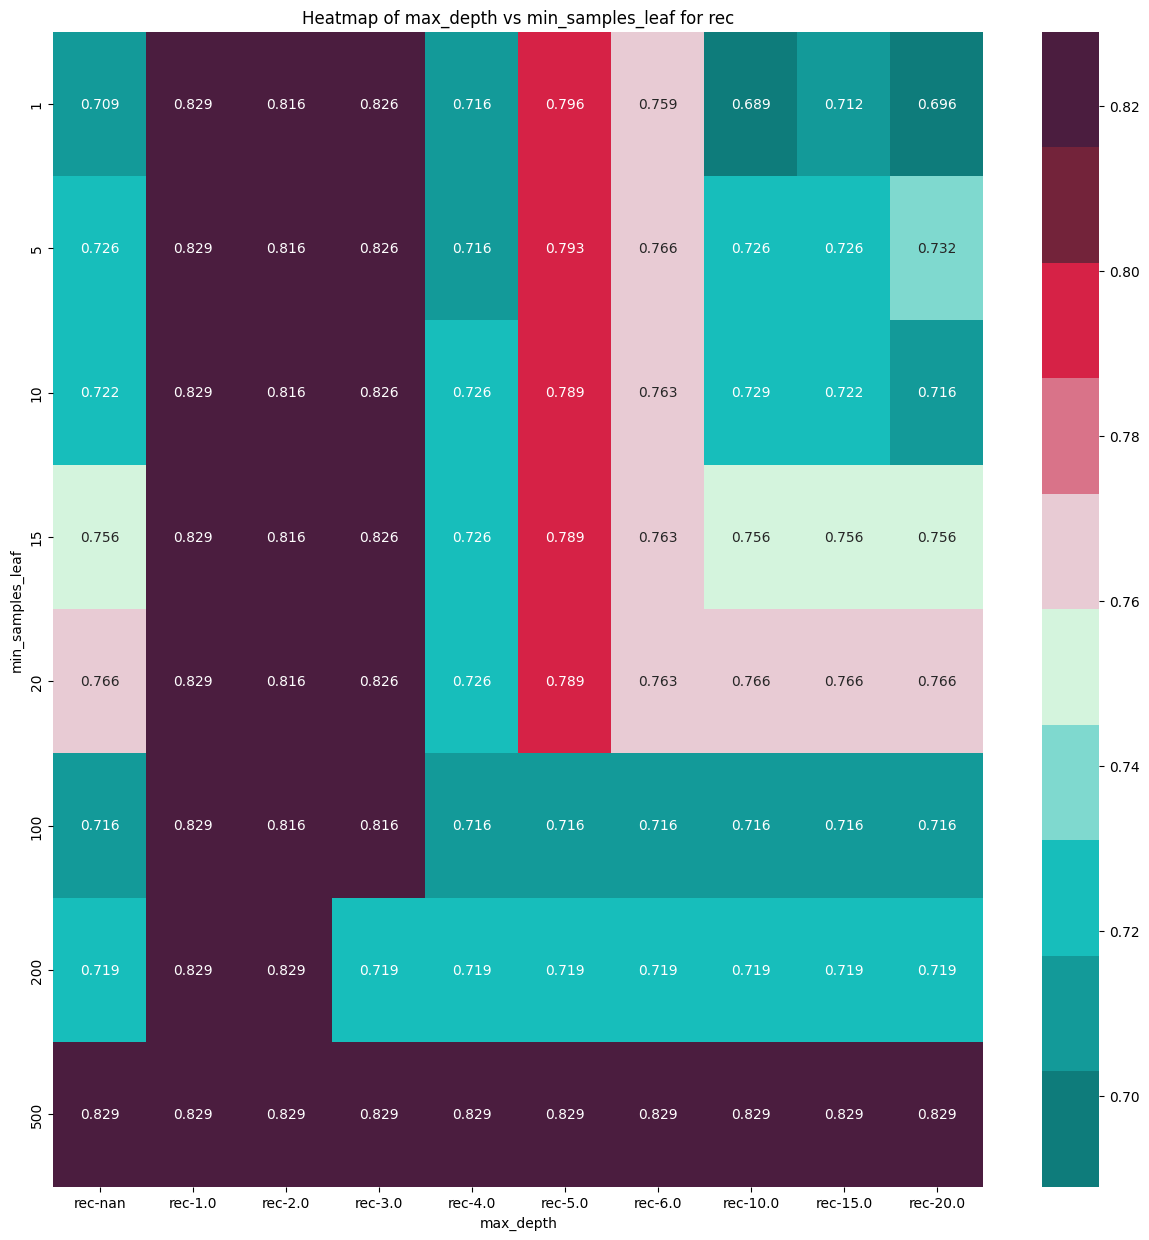

In [28]:
for metric in metrics:
    plot_dt_ft_eval(pivot_tables[f"dt_{metric}_pivot"], metric)

In [29]:
for metric in metrics:
    long_df = (
            pivot_tables[f"dt_{metric}_pivot"].stack()
            .reset_index()
            .rename(columns={0: metric})
        )

    top5 = long_df.sort_values(by=metric, ascending=False).head(5)
    top5.round(3)
    print(top5)

    min_samples_leaf  max_depth   auc
59               100       20.0  0.94
58               100       15.0  0.94
50               100        NaN  0.94
55               100        5.0  0.94
57               100       10.0  0.94
    min_samples_leaf  max_depth     f1
2                  1        2.0  0.771
12                 5        2.0  0.771
32                15        2.0  0.771
52               100        2.0  0.771
53               100        3.0  0.771
    min_samples_leaf  max_depth    acc
35                15        5.0  0.882
45                20        5.0  0.882
25                10        5.0  0.882
15                 5        5.0  0.881
59               100       20.0  0.880
    min_samples_leaf  max_depth   prec
59               100       20.0  0.784
50               100        NaN  0.784
54               100        4.0  0.784
55               100        5.0  0.784
57               100       10.0  0.784
    min_samples_leaf  max_depth    rec
1                  1        1.0

/tmp/ipykernel_33639/2778617044.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_tables[f"dt_{metric}_pivot"].stack()
/tmp/ipykernel_33639/2778617044.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_tables[f"dt_{metric}_pivot"].stack()
/tmp/ipykernel_33639/2778617044.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_tables[f"dt_{metric}

100 min samples consistentley lead to good performance, across the most metrics, auc f1 and precision. 

5 was the most common max depth, that seems to not get too deep but get good performance. This may lead to better generalisation down the line.

### Random Forest Parameter Tuning

We will tune the following parameters:
- n_estimators
- max_depth
- min_samples_leaf

#### N estimators

In [30]:
rf_ft_scores = []

for n in range(10, 301, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred >= 0.5)
    acc = accuracy_score(y_val, y_pred >= 0.5)
    prec = precision_score(y_val, y_pred >= 0.5)
    rec = recall_score(y_val, y_pred >= 0.5)

    rf_ft_scores.append((n, auc, f1, acc, prec, rec))
    

In [31]:
columns = ['n_estimators', 'auc', 'f1', 'acc', 'prec', 'rec']
df_rf_ne_scores = pd.DataFrame(rf_ft_scores, columns=columns)

In [32]:
df_rf_ne_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,auc,f1,acc,prec,rec
29,300,0.929580,0.752941,0.877500,0.756757,0.749164
27,280,0.929495,0.750842,0.876667,0.755932,0.745819
28,290,0.929449,0.750842,0.876667,0.755932,0.745819
26,270,0.929376,0.750842,0.876667,0.755932,0.745819
25,260,0.929311,0.746622,0.875000,0.754266,0.739130


In [33]:
df_rf_ne_scores.sort_values(by='f1', ascending=False).head()

,n_estimators,auc,f1,acc,prec,rec
29,300,0.929580,0.752941,0.877500,0.756757,0.749164
12,130,0.928968,0.751678,0.876667,0.754209,0.749164
26,270,0.929376,0.750842,0.876667,0.755932,0.745819
28,290,0.929449,0.750842,0.876667,0.755932,0.745819
27,280,0.929495,0.750842,0.876667,0.755932,0.745819


In [34]:
df_rf_ne_scores.sort_values(by='rec', ascending=False).head()

,n_estimators,auc,f1,acc,prec,rec
2,30,0.920363,0.747941,0.872500,0.737013,0.759197
12,130,0.928968,0.751678,0.876667,0.754209,0.749164
11,120,0.929033,0.750419,0.875833,0.751678,0.749164
29,300,0.929580,0.752941,0.877500,0.756757,0.749164
27,280,0.929495,0.750842,0.876667,0.755932,0.745819


In [35]:
def plot_rf_n_estimators(metric):
    sns.lineplot(x=df_rf_ne_scores.n_estimators, y=df_rf_ne_scores[metric])
    plt.title(f"n_estimators vs {metric}")
    plt.xlabel("n_estimators")
    plt.ylabel(metric)
    plt.show()


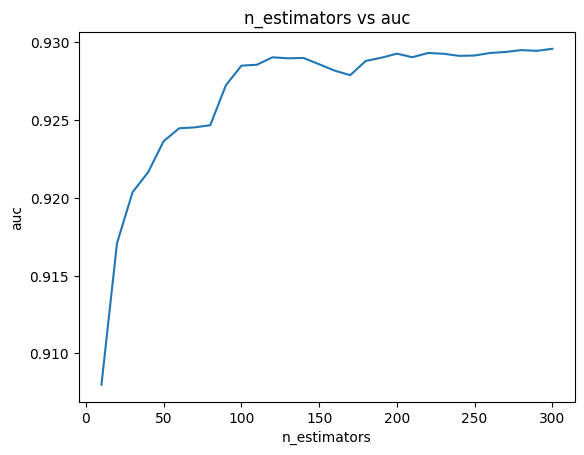

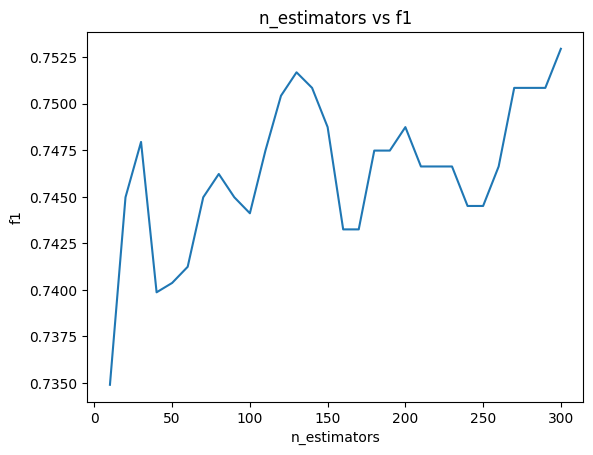

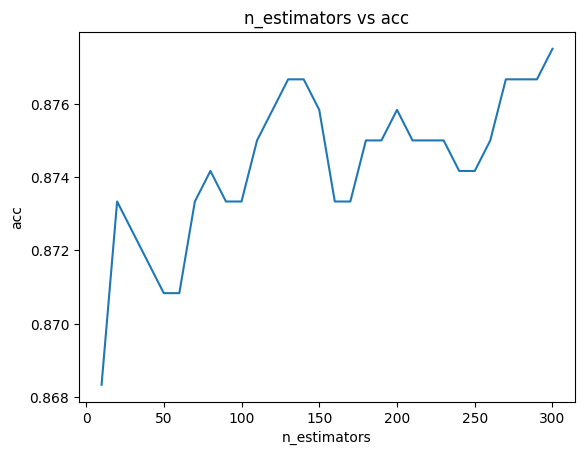

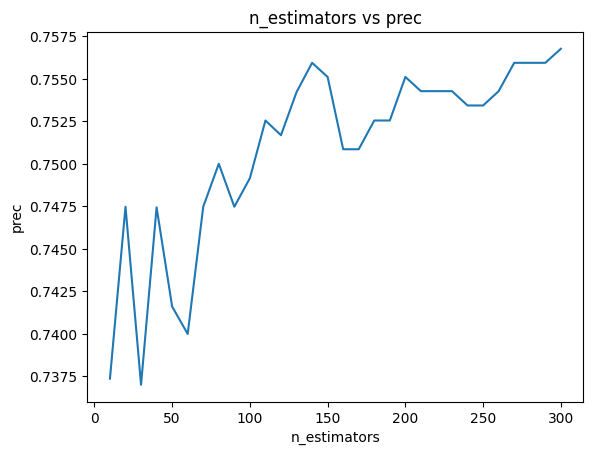

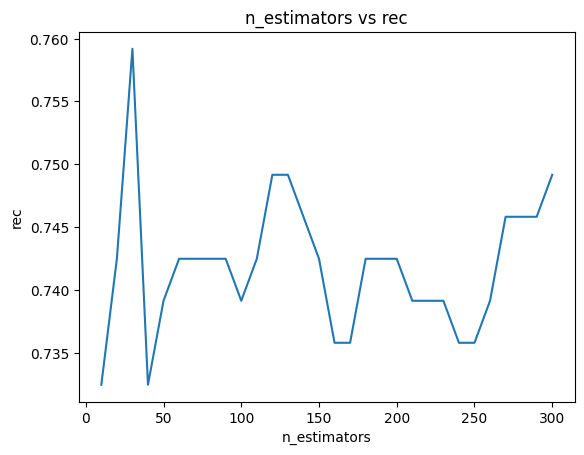

In [36]:
for metric in metrics:
    plot_rf_n_estimators(metric)

#### Max depth

In [37]:
depths = [1, 3, 5, 10, 15, 20, None]

rf_md_scores = []
for d in depths:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred >= 0.5)
        acc = accuracy_score(y_val, y_pred >= 0.5)
        prec = precision_score(y_val, y_pred >= 0.5)
        rec = recall_score(y_val, y_pred >= 0.5)

        rf_md_scores.append((n, d, auc, f1, acc, prec, rec))

In [38]:
columns = ['n_estimators', 'max_depth', 'auc', 'f1', 'acc', 'prec', 'rec']
df_rf_md_scores = pd.DataFrame(rf_md_scores, columns=columns)

In [39]:
df_rf_md_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,max_depth,auc,f1,acc,prec,rec
79,200,5.0,0.943227,0.766506,0.879167,0.739130,0.795987
84,250,5.0,0.943179,0.768489,0.880000,0.739938,0.799331
82,230,5.0,0.943164,0.768489,0.880000,0.739938,0.799331
80,210,5.0,0.943157,0.766506,0.879167,0.739130,0.795987
81,220,5.0,0.943153,0.768489,0.880000,0.739938,0.799331


In [40]:
df_rf_md_scores.sort_values(by='f1', ascending=False).head()

,n_estimators,max_depth,auc,f1,acc,prec,rec
96,70,10.0,0.939074,0.773333,0.886667,0.770764,0.775920
112,230,10.0,0.939682,0.772047,0.885833,0.768212,0.775920
110,210,10.0,0.939508,0.771523,0.885000,0.763934,0.779264
97,80,10.0,0.939066,0.770764,0.885000,0.765677,0.775920
70,110,5.0,0.942396,0.769726,0.880833,0.742236,0.799331


In [41]:
df_rf_md_scores.sort_values(by='rec', ascending=False).head()

,n_estimators,max_depth,auc,f1,acc,prec,rec
72,130,5.0,0.942550,0.768489,0.880000,0.739938,0.799331
81,220,5.0,0.943153,0.768489,0.880000,0.739938,0.799331
69,100,5.0,0.942359,0.768489,0.880000,0.739938,0.799331
71,120,5.0,0.942433,0.769726,0.880833,0.742236,0.799331
70,110,5.0,0.942396,0.769726,0.880833,0.742236,0.799331


In [42]:
rf_pivot_tables = {}

metrics = ['auc', 'f1', 'acc', 'prec', 'rec']

for metric in metrics:
    rf_pivot_tables[f"rf_{metric}_pivot"] = df_rf_md_scores.pivot(index='n_estimators', columns='max_depth', values=[metric])
    rf_pivot_tables[f"rf_{metric}_pivot"] = rf_pivot_tables[f"rf_{metric}_pivot"].round(3)

In [43]:
rf_pivot_tables[f"rf_rec_pivot"]

rec                                          
max_depth       NaN   1.0    3.0    5.0    10.0   15.0   20.0
n_estimators                                                 
10            0.732  0.475  0.776  0.783  0.756  0.759  0.739
20            0.742  0.475  0.773  0.789  0.759  0.749  0.739
30            0.759  0.656  0.773  0.786  0.749  0.753  0.739
40            0.732  0.753  0.779  0.789  0.766  0.759  0.719
50            0.739  0.712  0.779  0.786  0.759  0.759  0.729
60            0.742  0.712  0.779  0.793  0.773  0.766  0.722
70            0.742  0.712  0.779  0.789  0.776  0.769  0.726
80            0.742  0.712  0.779  0.793  0.776  0.766  0.729
90            0.742  0.712  0.783  0.793  0.769  0.766  0.732
100           0.739  0.753  0.783  0.799  0.766  0.763  0.736
110           0.742  0.712  0.783  0.799  0.769  0.763  0.736
120           0.749  0.712  0.786  0.799  0.766  0.763  0.742
130           0.749  0.786  0.786  0.799  0.773  0.763  0.742
140           0.746  0.789  0.786  0.793  0.769  0.769  0.742
150           0.742  0.796  0.783  0.793  0.773  0.759  0.739
160           0.736  0.796  0.783  0.793  0.769  0.766  0.746
170           0.736  0.796  0.786  0.793  0.769  0.763  0.742
180           0.742  0.796  0.793  0.796  0.773  0.753  0.742
190           0.742  0.796  0.786  0.796  0.776  0.756  0.746
200           0.742  0.796  0.793  0.796  0.773  0.753  0.746
210           0.739  0.796  0.786  0.796  0.779  0.763  0.739
220           0.739  0.796  0.783  0.799  0.776  0.756  0.739
230           0.739  0.796  0.786  0.799  0.776  0.753  0.742
240           0.736  0.796  0.789  0.799  0.773  0.756  0.742
250           0.736  0.796  0.786  0.799  0.769  0.753  0.739
260           0.739  0.789  0.783  0.799  0.773  0.756  0.742
270           0.746  0.789  0.783  0.799  0.773  0.753  0.742
280           0.746  0.789  0.783  0.799  0.773  0.753  0.742
290           0.746  0.796  0.783  0.799  0.773  0.759  0.742
300           0.749  0.796  0.783  0.799  0.773  0.756  0.742

/tmp/ipykernel_33639/1799455382.py:7: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_rf_md_scores, x='n_estimators', y='auc', hue='max_depth', palette=cmap)


Text(0.5, 1.0, 'max_depth of 5.0 and n_estimators of 200.0 leads to best AUC\n')

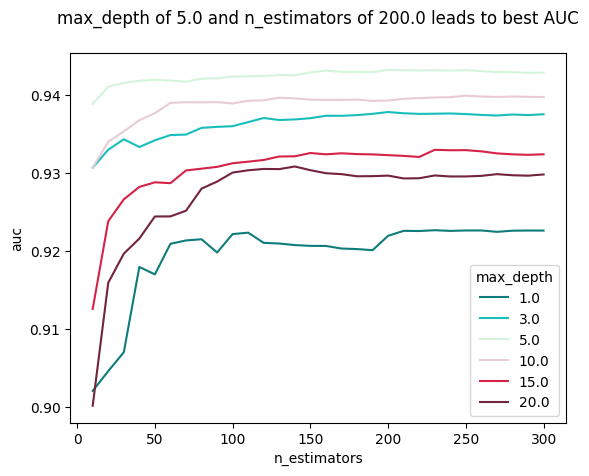

In [44]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']

max_idx = df_rf_md_scores['auc'].idxmax()

best_row = df_rf_md_scores.loc[max_idx]

sns.lineplot(data=df_rf_md_scores, x='n_estimators', y='auc', hue='max_depth', palette=cmap)
plt.title(f"max_depth of {best_row['max_depth']} and n_estimators of {best_row['n_estimators']} leads to best AUC\n")

/tmp/ipykernel_33639/2233034257.py:9: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_rf_md_scores, x='n_estimators', y=df_rf_md_scores[metric], hue='max_depth', palette=cmap)


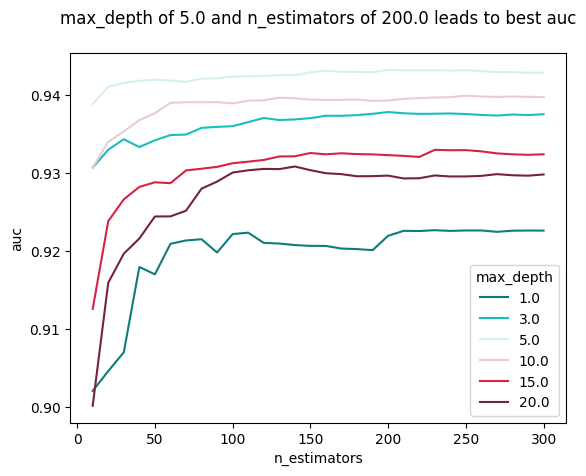

/tmp/ipykernel_33639/2233034257.py:9: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_rf_md_scores, x='n_estimators', y=df_rf_md_scores[metric], hue='max_depth', palette=cmap)


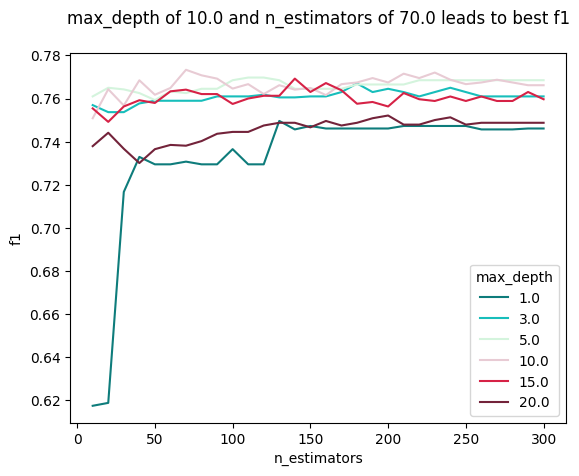

/tmp/ipykernel_33639/2233034257.py:9: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_rf_md_scores, x='n_estimators', y=df_rf_md_scores[metric], hue='max_depth', palette=cmap)


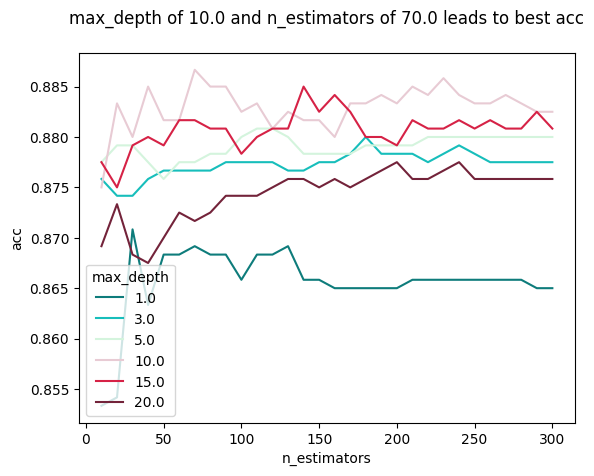

/tmp/ipykernel_33639/2233034257.py:9: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_rf_md_scores, x='n_estimators', y=df_rf_md_scores[metric], hue='max_depth', palette=cmap)


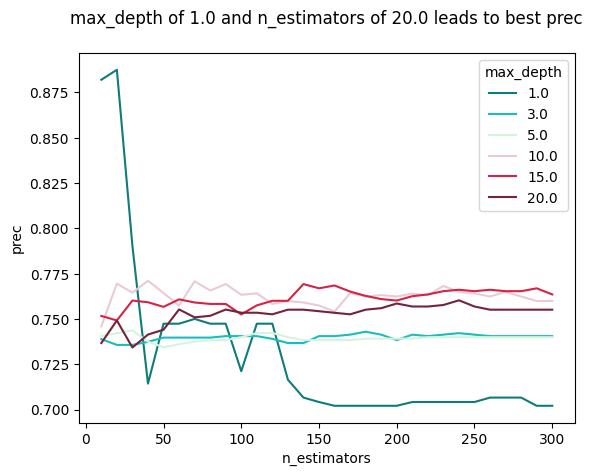

/tmp/ipykernel_33639/2233034257.py:9: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(data=df_rf_md_scores, x='n_estimators', y=df_rf_md_scores[metric], hue='max_depth', palette=cmap)


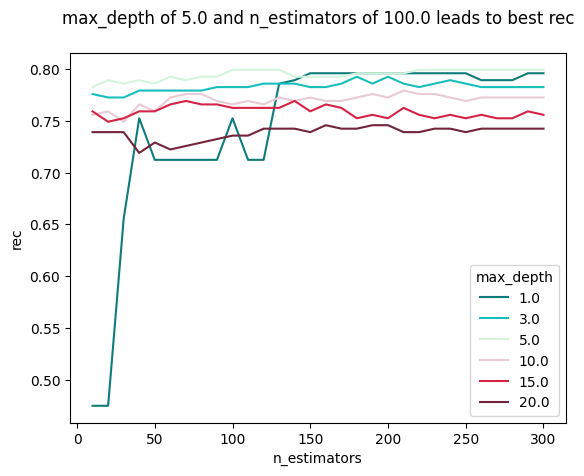

In [45]:
for metric in metrics:

    cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']

    max_idx = df_rf_md_scores[metric].idxmax()

    best_row = df_rf_md_scores.loc[max_idx]

    sns.lineplot(data=df_rf_md_scores, x='n_estimators', y=df_rf_md_scores[metric], hue='max_depth', palette=cmap)
    plt.title(f"max_depth of {best_row['max_depth']} and n_estimators of {best_row['n_estimators']} leads to best {metric}\n")
    plt.show()

AUC remains high for max depth 5 across all of the n_estimator values. This could be due to the imbalance of the target value. As we want to minimise Type II errors (false negatives), we should priortise recall and to a lesser extent f1 score. 1, 3 and  5 max depth offer similar recall. We will focus on these when optimising min_sample_leaf.

#### Min sample leaf

In [46]:
rf_ms_scores = []
min_samples = [1, 3, 5, 10, 50]
for s in min_samples:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=n, 
            max_depth=5, 
            min_samples_leaf=s,
            random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred >= 0.5)
        acc = accuracy_score(y_val, y_pred >= 0.5)
        prec = precision_score(y_val, y_pred >= 0.5)
        rec = recall_score(y_val, y_pred >= 0.5)

        rf_ms_scores.append((n, s, auc, f1, acc, prec, rec))

In [47]:
columns = ['n_estimators', 'min_samples_leaf', 'auc', 'f1', 'acc', 'prec', 'rec']
df_rf_ms_scores = pd.DataFrame(rf_ms_scores, columns=columns)

In [48]:
rf_ms_pivot_tables = {}

metrics = ['auc', 'f1', 'acc', 'prec', 'rec']

for metric in metrics:
    rf_ms_pivot_tables[f"rf_{metric}_pivot"] = df_rf_ms_scores.pivot(index='n_estimators', columns='min_samples_leaf', values=[metric])
    rf_ms_pivot_tables[f"rf_{metric}_pivot"] = rf_ms_pivot_tables[f"rf_{metric}_pivot"].round(3)

In [49]:
rf_ms_pivot_tables[f"rf_rec_pivot"]

rec                            
min_samples_leaf     1      3      5      10     50
n_estimators                                       
10                0.783  0.783  0.779  0.776  0.766
20                0.789  0.779  0.779  0.759  0.769
30                0.786  0.783  0.773  0.773  0.763
40                0.789  0.789  0.789  0.786  0.776
50                0.786  0.799  0.786  0.783  0.773
60                0.793  0.799  0.793  0.786  0.773
70                0.789  0.789  0.796  0.783  0.776
80                0.793  0.793  0.793  0.783  0.776
90                0.793  0.796  0.796  0.783  0.776
100               0.799  0.799  0.799  0.786  0.779
110               0.799  0.799  0.799  0.786  0.779
120               0.799  0.799  0.799  0.789  0.779
130               0.799  0.799  0.799  0.786  0.779
140               0.793  0.796  0.796  0.779  0.779
150               0.793  0.793  0.796  0.779  0.779
160               0.793  0.796  0.796  0.779  0.779
170               0.793  0.796  0.796  0.779  0.779
180               0.796  0.796  0.799  0.779  0.779
190               0.796  0.796  0.799  0.779  0.779
200               0.796  0.799  0.796  0.783  0.779

/tmp/ipykernel_33639/3460509484.py:9: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_rf_ms_scores, x='n_estimators', y=df_rf_ms_scores[metric], hue='min_samples_leaf', palette=cmap)


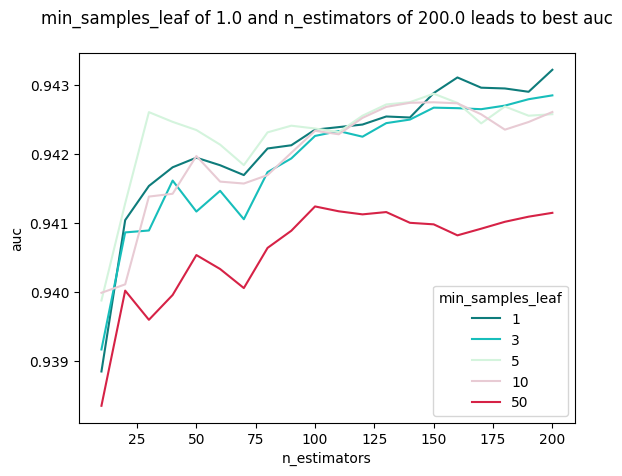

/tmp/ipykernel_33639/3460509484.py:9: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_rf_ms_scores, x='n_estimators', y=df_rf_ms_scores[metric], hue='min_samples_leaf', palette=cmap)


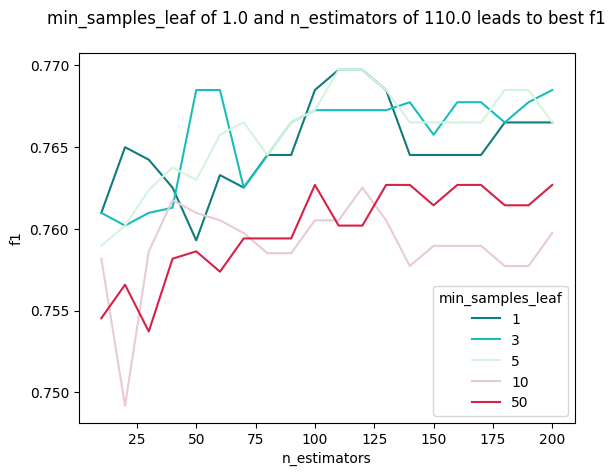

/tmp/ipykernel_33639/3460509484.py:9: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_rf_ms_scores, x='n_estimators', y=df_rf_ms_scores[metric], hue='min_samples_leaf', palette=cmap)


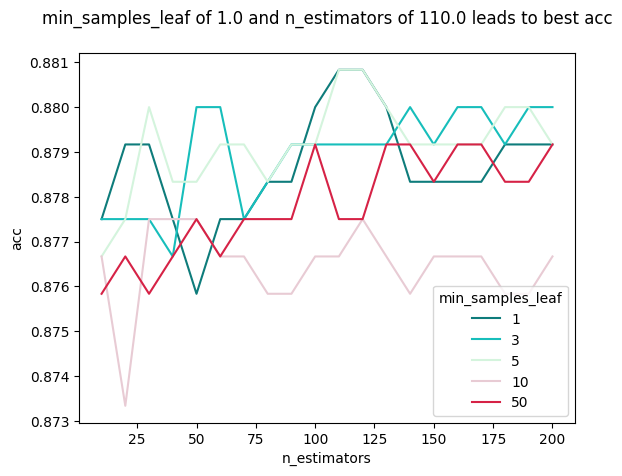

/tmp/ipykernel_33639/3460509484.py:9: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_rf_ms_scores, x='n_estimators', y=df_rf_ms_scores[metric], hue='min_samples_leaf', palette=cmap)


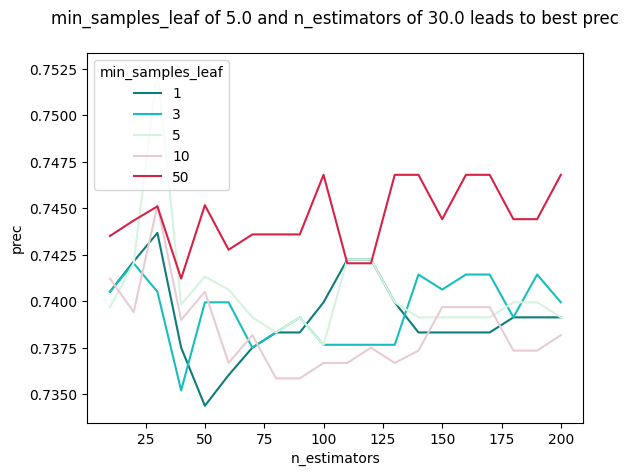

/tmp/ipykernel_33639/3460509484.py:9: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_rf_ms_scores, x='n_estimators', y=df_rf_ms_scores[metric], hue='min_samples_leaf', palette=cmap)


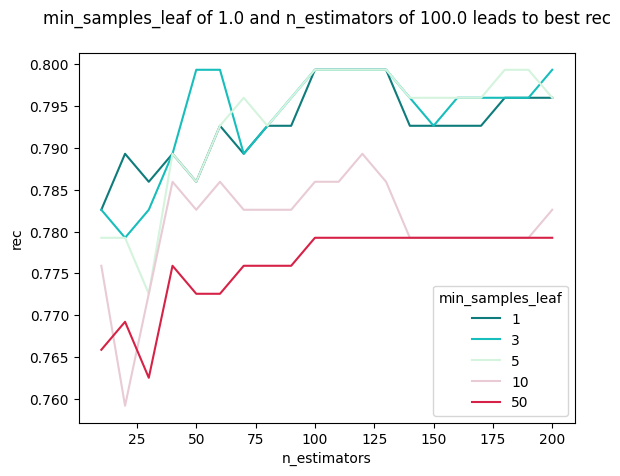

In [50]:
for metric in metrics:

    cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']

    max_idx = df_rf_ms_scores[metric].idxmax()

    best_row = df_rf_ms_scores.loc[max_idx]

    sns.lineplot(data=df_rf_ms_scores, x='n_estimators', y=df_rf_ms_scores[metric], hue='min_samples_leaf', palette=cmap)
    plt.title(f"min_samples_leaf of {best_row['min_samples_leaf']} and n_estimators of {best_row['n_estimators']} leads to best {metric}\n")
    plt.show()

In [51]:
# Best model
rf = RandomForestClassifier(
            n_estimators=10, 
            max_depth=5, 
            min_samples_leaf=3,
            random_state=42)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost Parameter Tuning

In this subsection we will fine tune the following parameters:
- num_iter
- eta (Learning Rate)
- max_depth
- min_child_weight


#### Initial performance with 200 iterations

In [52]:
features = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, "train"), (dval, "val")]
evals_result = {}


xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, evals_result=evals_result)

y_pred = model.predict(dval)





[0]	train-auc:0.95188	val-auc:0.93867
[1]	train-auc:0.95676	val-auc:0.94014
[2]	train-auc:0.95884	val-auc:0.93936
[3]	train-auc:0.96027	val-auc:0.93844
[4]	train-auc:0.96172	val-auc:0.93739
[5]	train-auc:0.96261	val-auc:0.93843
[6]	train-auc:0.96354	val-auc:0.93938
[7]	train-auc:0.96544	val-auc:0.93756
[8]	train-auc:0.96648	val-auc:0.93826
[9]	train-auc:0.96762	val-auc:0.93803
[10]	train-auc:0.96888	val-auc:0.93911
[11]	train-auc:0.96966	val-auc:0.93936
[12]	train-auc:0.97083	val-auc:0.93977
[13]	train-auc:0.97155	val-auc:0.93981
[14]	train-auc:0.97210	val-auc:0.93992
[15]	train-auc:0.97268	val-auc:0.93919
[16]	train-auc:0.97328	val-auc:0.93972
[17]	train-auc:0.97406	val-auc:0.93966
[18]	train-auc:0.97541	val-auc:0.93848
[19]	train-auc:0.97640	val-auc:0.93900
[20]	train-auc:0.97732	val-auc:0.93864
[21]	train-auc:0.97788	val-auc:0.93830
[22]	train-auc:0.97897	val-auc:0.93820
[23]	train-auc:0.97937	val-auc:0.93821
[24]	train-auc:0.98024	val-auc:0.93797
[25]	train-auc:0.98054	val-auc:0.93

In [53]:
evals_result

{'train': OrderedDict([('auc',
               [0.951877177405087,
                0.9567633694945857,
                0.9588415667561191,
                0.9602744997858764,
                0.9617206605257023,
                0.9626122908575029,
                0.9635442243684181,
                0.9654390938357218,
                0.9664811893695509,
                0.967619185801376,
                0.9688770583556965,
                0.9696634870558589,
                0.9708266988100022,
                0.9715455421790338,
                0.9720951121957834,
                0.9726765113898851,
                0.9732816791255161,
                0.9740559135304593,
                0.975409480299806,
                0.9763963914806933,
                0.9773167507452988,
                0.9778797551550866,
                0.9789712479187025,
                0.9793666324399669,
                0.9802429682320009,
                0.9805397649766614,
                0.9810291902491936,


<Axes: >

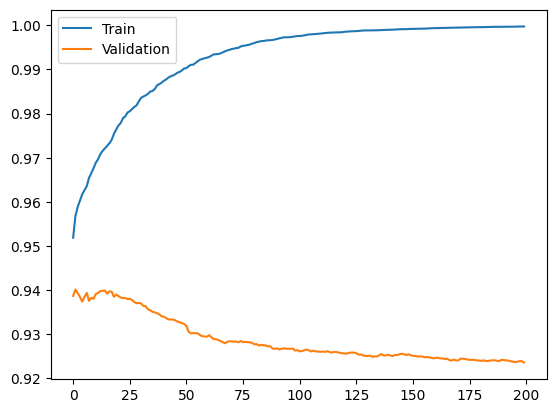

In [54]:
sns.lineplot(evals_result['train']['auc'], label='Train')
sns.lineplot(evals_result['val']['auc'], label='Validation')


Performance seems to tail off quite substantially. Moving forward, with the final model, I will implement early stopping when if performance doesn't improve for a number of rounds. I will keep the number of iterations for now while testing parameters.

#### eta (Learning Rate) tuning

In [55]:
def recall_metric(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = (preds > 0.5).astype(int)
    tp = ((preds_binary == 1) & (labels == 1)).sum()
    fn = ((preds_binary == 0) & (labels == 1)).sum()
    recall = tp / (tp + fn + 1e-10)
    return 'recall', recall

In [56]:
xgb_eta_scores = {}
xgb_eta_rec_scores = {}

etas = [0.001, 0.01, 0.05, 0.1, 0.3, 1.0]

for eta in etas:   
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 42,
        'verbosity': 1,
    }

   
    model = xgb.train(xgb_params, dtrain, 
                    evals=watchlist, 
                    evals_result=evals_result,
                    num_boost_round=200,
                    custom_metric=recall_metric
                    )
    
    xgb_eta_scores[f'eta={eta}'] = evals_result['val']['auc']
    xgb_eta_rec_scores[f'eta={eta}'] = evals_result['val']['recall']

[0]	train-auc:0.95188	train-recall:0.00000	val-auc:0.93867	val-recall:0.00000
[1]	train-auc:0.95187	train-recall:0.00000	val-auc:0.93841	val-recall:0.00000
[2]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93836	val-recall:0.00000
[3]	train-auc:0.95187	train-recall:0.00000	val-auc:0.93841	val-recall:0.00000
[4]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93839	val-recall:0.00000
[5]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93836	val-recall:0.00000
[6]	train-auc:0.95188	train-recall:0.00000	val-auc:0.93841	val-recall:0.00000
[7]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93836	val-recall:0.00000
[8]	train-auc:0.95188	train-recall:0.00000	val-auc:0.93841	val-recall:0.00000
[9]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93839	val-recall:0.00000
[10]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93836	val-recall:0.00000
[11]	train-auc:0.95193	train-recall:0.00000	val-auc:0.93841	val-recall:0.00000
[12]	train-auc:0.95192	train-recall:0.00000	val-auc:0.93839	va

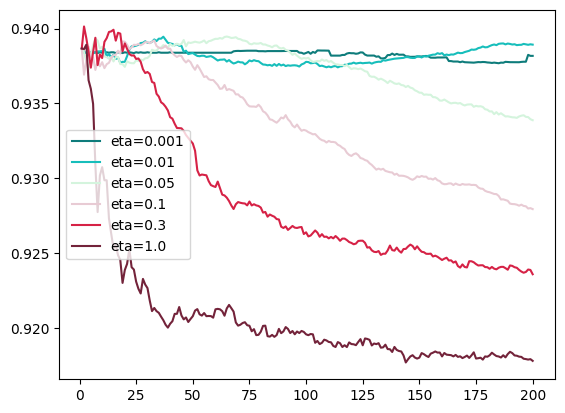

In [57]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']
for c, (key, auc_list) in zip(cmap, xgb_eta_scores.items()):
    num_iters = list(range(1, len(auc_list) + 1))
    sns.lineplot(x=num_iters, y=auc_list, label=key, color=c)

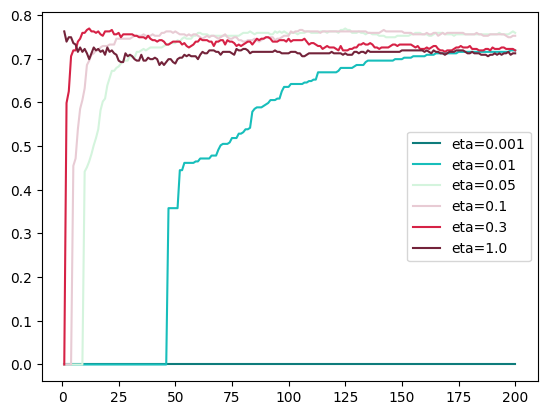

In [58]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']
for c, (key, auc_list) in zip(cmap, xgb_eta_rec_scores.items()):
    num_iters = list(range(1, len(auc_list) + 1))
    sns.lineplot(x=num_iters, y=auc_list, label=key, color=c)

In [59]:
best_eta = max(xgb_eta_scores, key=lambda k: max(xgb_eta_scores[k]))
best_auc = max(xgb_eta_scores[best_eta])

print("Best eta:", best_eta)
print("Best AUC:", best_auc)

Best eta: eta=0.3
Best AUC: 0.9401371200338531


In [60]:
best_eta = max(xgb_eta_rec_scores, key=lambda k: max(xgb_eta_rec_scores[k]))
best_rec = max(xgb_eta_rec_scores[best_eta])

print("Best eta:", best_eta)
print("Best Recall:", best_rec)

Best eta: eta=0.05
Best Recall: 0.769231


#### max_depth parameter tuning

In [61]:
xgb_md_scores = {}
xgb_md_rec_scores = {}

depths = [1, 3, 5, 10, 15, 20]

for md in depths:   
    xgb_params = {
        'eta': 0.3,
        'max_depth': md,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 42,
        'verbosity': 1,
    }

   
    model = xgb.train(xgb_params, dtrain, 
                    evals=watchlist, 
                    evals_result=evals_result,
                    num_boost_round=200,
                    custom_metric=recall_metric
                    )
    
    xgb_md_scores[f'md={md}'] = evals_result['val']['auc']
    xgb_md_rec_scores[f'md={md}'] = evals_result['val']['recall']

[0]	train-auc:0.86246	train-recall:0.00000	val-auc:0.84757	val-recall:0.00000


[1]	train-auc:0.86246	train-recall:0.00000	val-auc:0.84757	val-recall:0.00000
[2]	train-auc:0.89299	train-recall:0.50895	val-auc:0.87503	val-recall:0.47492
[3]	train-auc:0.93000	train-recall:0.50895	val-auc:0.92061	val-recall:0.47492
[4]	train-auc:0.93488	train-recall:0.82103	val-auc:0.92423	val-recall:0.77592
[5]	train-auc:0.93657	train-recall:0.81544	val-auc:0.92513	val-recall:0.77258
[6]	train-auc:0.93540	train-recall:0.82103	val-auc:0.92433	val-recall:0.77592
[7]	train-auc:0.94354	train-recall:0.74049	val-auc:0.93115	val-recall:0.69231
[8]	train-auc:0.94538	train-recall:0.74273	val-auc:0.93339	val-recall:0.69231
[9]	train-auc:0.94420	train-recall:0.81991	val-auc:0.93194	val-recall:0.77592
[10]	train-auc:0.94528	train-recall:0.84005	val-auc:0.93340	val-recall:0.79933
[11]	train-auc:0.94526	train-recall:0.81991	val-auc:0.93320	val-recall:0.77592
[12]	train-auc:0.94554	train-recall:0.84005	val-auc:0.93353	val-recall:0.79933
[13]	train-auc:0.94667	train-recall:0.84005	val-auc:0.93530	v

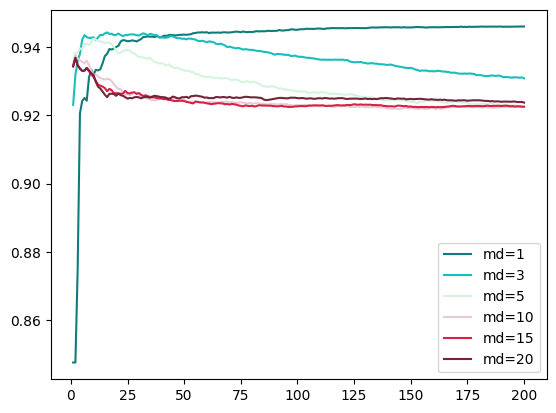

In [62]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']
for c, (key, auc_list) in zip(cmap, xgb_md_scores.items()):
    num_iters = list(range(1, len(auc_list) + 1))
    sns.lineplot(x=num_iters, y=auc_list, label=key, color=c)

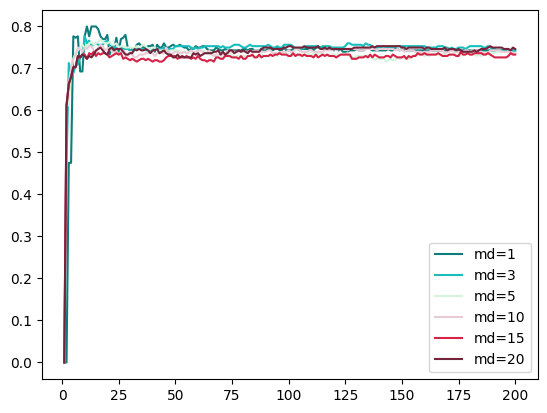

In [63]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']
for c, (key, auc_list) in zip(cmap, xgb_md_rec_scores.items()):
    num_iters = list(range(1, len(auc_list) + 1))
    sns.lineplot(x=num_iters, y=auc_list, label=key, color=c)

In [64]:
best_md = max(xgb_md_scores, key=lambda k: max(xgb_md_scores[k]))
best_auc = max(xgb_md_scores[best_md])

print("Best md:", best_md)
print("Best AUC:", best_auc)

Best md: md=1
Best AUC: 0.9460929699070895


In [65]:
best_md = max(xgb_md_rec_scores, key=lambda k: max(xgb_md_rec_scores[k]))
best_rec = max(xgb_md_rec_scores[best_md])

print("Best md:", best_md)
print("Best rcall:", best_rec)

Best md: md=1
Best rcall: 0.799331


#### min_child_weights parameter tuning

In [66]:
xgb_mcw_scores = {}
xgb_mcw_rec_scores = {}

min_child_weights = [1, 10, 15, 20, 30, 40]

for w in min_child_weights:   
    xgb_params = {
        'eta': 0.3,
        'max_depth': 1,
        'min_child_weight': w,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 42,
        'verbosity': 1,
    }

   
    model = xgb.train(xgb_params, dtrain, 
                    evals=watchlist, 
                    evals_result=evals_result,
                    num_boost_round=200,
                    custom_metric=recall_metric
                    )
    
    xgb_mcw_scores[f'mcw={w}'] = evals_result['val']['auc']
    xgb_mcw_rec_scores[f'mcw={w}'] = evals_result['val']['recall']

[0]	train-auc:0.86246	train-recall:0.00000	val-auc:0.84757	val-recall:0.00000
[1]	train-auc:0.86246	train-recall:0.00000	val-auc:0.84757	val-recall:0.00000
[2]	train-auc:0.89299	train-recall:0.50895	val-auc:0.87503	val-recall:0.47492
[3]	train-auc:0.93000	train-recall:0.50895	val-auc:0.92061	val-recall:0.47492
[4]	train-auc:0.93488	train-recall:0.82103	val-auc:0.92423	val-recall:0.77592
[5]	train-auc:0.93657	train-recall:0.81544	val-auc:0.92513	val-recall:0.77258


[6]	train-auc:0.93540	train-recall:0.82103	val-auc:0.92433	val-recall:0.77592
[7]	train-auc:0.94354	train-recall:0.74049	val-auc:0.93115	val-recall:0.69231
[8]	train-auc:0.94538	train-recall:0.74273	val-auc:0.93339	val-recall:0.69231
[9]	train-auc:0.94420	train-recall:0.81991	val-auc:0.93194	val-recall:0.77592
[10]	train-auc:0.94528	train-recall:0.84005	val-auc:0.93340	val-recall:0.79933
[11]	train-auc:0.94526	train-recall:0.81991	val-auc:0.93320	val-recall:0.77592
[12]	train-auc:0.94554	train-recall:0.84005	val-auc:0.93353	val-recall:0.79933
[13]	train-auc:0.94667	train-recall:0.84005	val-auc:0.93530	val-recall:0.79933
[14]	train-auc:0.94775	train-recall:0.84005	val-auc:0.93744	val-recall:0.79933
[15]	train-auc:0.94809	train-recall:0.83893	val-auc:0.93805	val-recall:0.79264
[16]	train-auc:0.94945	train-recall:0.80649	val-auc:0.93948	val-recall:0.77592
[17]	train-auc:0.94945	train-recall:0.81320	val-auc:0.93932	val-recall:0.76923
[18]	train-auc:0.94967	train-recall:0.81320	val-auc:0.93

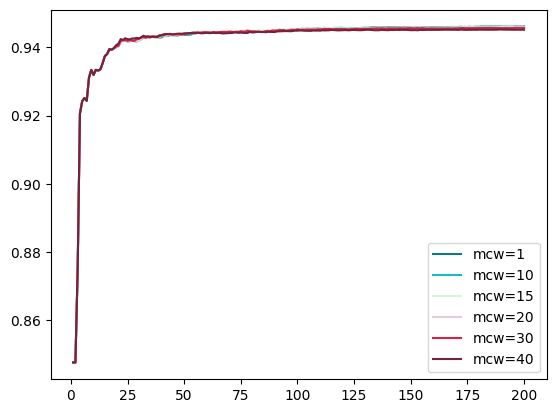

In [67]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']
for c, (key, auc_list) in zip(cmap, xgb_mcw_scores.items()):
    num_iters = list(range(1, len(auc_list) + 1))
    sns.lineplot(x=num_iters, y=auc_list, label=key, color=c)

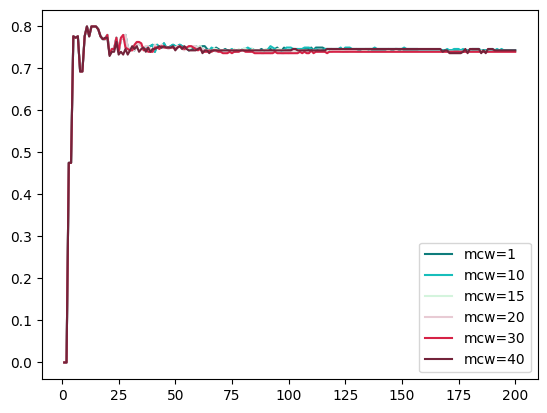

In [68]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF','#E8CBD4FF',  '#D62246FF', '#73233AFF','#4B1D3FFF']
for c, (key, auc_list) in zip(cmap, xgb_mcw_rec_scores.items()):
    num_iters = list(range(1, len(auc_list) + 1))
    sns.lineplot(x=num_iters, y=auc_list, label=key, color=c)

In [69]:
best_mcw = max(xgb_mcw_scores, key=lambda k: max(xgb_mcw_scores[k]))
best_auc = max(xgb_mcw_scores[best_mcw])

print("Best mcw:", best_mcw)
print("Best AUC:", best_auc)

Best mcw: mcw=10
Best AUC: 0.9461356575191444


In [70]:
best_mcw = max(xgb_mcw_rec_scores, key=lambda k: max(xgb_mcw_rec_scores[k]))
best_rec = max(xgb_mcw_rec_scores[best_mcw])

print("Best mcw:", best_mcw)
print("Best recall:", best_rec)

Best mcw: mcw=1
Best recall: 0.799331


## Selecting the best model

In [71]:
best_model_scores = []

In [72]:
best_model_scores

[]

In [73]:
## Best Decision Tree Model
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]

model = "Decision Tree"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)

best_model_scores.append((model, auc, f1, acc, prec, rec))

In [74]:
## Best Random Forest Model

rf = RandomForestClassifier(
            n_estimators=10, 
            max_depth=5, 
            min_samples_leaf=3,
            random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]

model = "Random Forest"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)

best_model_scores.append((model, auc, f1, acc, prec, rec))

In [75]:
## best XGBoost model

xgb_params = {
        'eta': 0.3,
        'max_depth': 1,
        'min_child_weight': 10,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 42,
        'verbosity': 1,
    }

   
model = xgb.train(xgb_params, dtrain, 
                    evals=watchlist, 
                    evals_result=evals_result,
                    num_boost_round=200,
                    custom_metric=recall_metric,
                    early_stopping_rounds=50
                    )

y_pred = model.predict(dval)

model = "XGBoost"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
best_model_scores.append((model, auc, f1, acc, prec, rec))


[0]	train-auc:0.86246	train-recall:0.00000	val-auc:0.84757	val-recall:0.00000
[1]	train-auc:0.86246	train-recall:0.00000	val-auc:0.84757	val-recall:0.00000
[2]	train-auc:0.89299	train-recall:0.50895	val-auc:0.87503	val-recall:0.47492


[3]	train-auc:0.93000	train-recall:0.50895	val-auc:0.92061	val-recall:0.47492
[4]	train-auc:0.93488	train-recall:0.82103	val-auc:0.92423	val-recall:0.77592
[5]	train-auc:0.93657	train-recall:0.81544	val-auc:0.92513	val-recall:0.77258
[6]	train-auc:0.93540	train-recall:0.82103	val-auc:0.92433	val-recall:0.77592
[7]	train-auc:0.94354	train-recall:0.74049	val-auc:0.93115	val-recall:0.69231
[8]	train-auc:0.94538	train-recall:0.74273	val-auc:0.93339	val-recall:0.69231
[9]	train-auc:0.94420	train-recall:0.81991	val-auc:0.93194	val-recall:0.77592
[10]	train-auc:0.94528	train-recall:0.84005	val-auc:0.93340	val-recall:0.79933
[11]	train-auc:0.94526	train-recall:0.81991	val-auc:0.93320	val-recall:0.77592
[12]	train-auc:0.94554	train-recall:0.84005	val-auc:0.93353	val-recall:0.79933
[13]	train-auc:0.94667	train-recall:0.84005	val-auc:0.93530	val-recall:0.79933
[14]	train-auc:0.94775	train-recall:0.84005	val-auc:0.93744	val-recall:0.79933
[15]	train-auc:0.94809	train-recall:0.83893	val-auc:0.93805

In [76]:
columns = ['model', 'auc', 'f1', 'acc', 'prec', 'rec']
df_best_model_scores = pd.DataFrame(best_model_scores, columns=columns)
df_best_model_scores

,model,auc,f1,acc,prec,rec
0,Decision Tree,0.940235,0.748252,0.880000,0.783883,0.715719
1,Random Forest,0.939170,0.760976,0.877500,0.740506,0.782609
2,XGBoost,0.943647,0.764007,0.884167,0.775862,0.752508


Random forest is the best model in this case, although the auc is a little lower than xgb, recall is much higher and f1 score. This will offer the best balance and minimise type II errors of the three.

## Apply best model to test data

In [77]:
df_full_train = df_full_train.reset_index(drop=True)

In [78]:
y_full_train = df_full_train.t2dm_risk.values

In [79]:
del df_full_train['t2dm_risk']

In [80]:
test_scores = []

# Create dictionaries for the feature matrix
dicts_full_train = df_full_train.to_dict(orient='records')

# Then vectorise those dictionaries
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

rf = RandomForestClassifier(
            n_estimators=10, 
            max_depth=5, 
            min_samples_leaf=3,
            random_state=42)
rf.fit(X_full_train, y_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

y_pred = rf.predict_proba(X_test)[:, 1]

model = "Random Forest"
auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred >= 0.5)
acc = accuracy_score(y_test, y_pred >= 0.5)
prec = precision_score(y_test, y_pred >= 0.5)
rec = recall_score(y_test, y_pred >= 0.5)

test_scores.append((model, auc, f1, acc, prec, rec))

In [81]:
columns = ['model', 'auc', 'f1', 'acc', 'prec', 'rec']
df_test_scores = pd.DataFrame(test_scores, columns=columns)
df_test_scores

,model,auc,f1,acc,prec,rec
0,Random Forest,0.947341,0.802528,0.895833,0.779141,0.827362


In [82]:
feature_names = dv.get_feature_names_out()
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.sort_values(ascending=False).head(10)

macrosomia_baby_birth_weightdelivered_a_baby_greater_than_3_5kg=no    0.138579
history_of_recurrence_of_gdm=yes                                      0.109410
history_of_recurrence_of_gdm=no                                       0.095976
insulin_treatment_during_pregnancy=yes                                0.089652
elevated_hba1c_during_pregnancy=elevated                              0.088240
large_for_gestational_age=yes                                         0.070068
large_for_gestational_age=no                                          0.060966
pregnancy_complications_hypertensive_disorders=no                     0.056567
pregnancy_complications_hypertensive_disorders=yes                    0.055745
elevated_hba1c_during_pregnancy=normal                                0.051269
dtype: float64

In [83]:
# Make pipeline

from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    DictVectorizer(), 
    RandomForestClassifier(
            n_estimators=10, 
            max_depth=5, 
            min_samples_leaf=3,
            random_state=42))



In [85]:
pipeline.fit(train_dicts, y_train)

,steps,"[('dictvectorizer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,True
,sort,True
,n_estimators,10
,criterion,'gini'
,max_depth,5


In [87]:

example_patient = {
    'older_maternal_age': 'yes',
    'high_pre_pregnancy_bmi_or_overweight': 'yes',
    'family_history_of_diabetes': 'yes',
    'socioeconomic_factors_deprivation_quintile': 2,
    'presence_of_t2dm_associated_gene_variants': 'no',
    'ethnicity': 'Asian',
    'multiparity': 'yes',
    'insulin_treatment_during_pregnancy': 'no',
    'pregnancy_complications_hypertensive_disorders': 'no',
    'pregnancy_complications_preterm_delivery': 'no',
    'pregnancy_complications_pph': 'no',
    'gestational_weight_gain': 'yes',
    'abnormal_ogtt_results': 'Abnormal',
    'elevated_hba1c_during_pregnancy': 'Normal',
    'large_for_gestational_age': 'no',
    'macrosomia_baby_birth_weightdelivered_a_baby_greater_than_3_5kg': 'no',
    'instrumental_delivery': 'no',
    'nicu_admission': 'no',
    'obesity_or_unhealthy_postpartum_weight_gain': 'no',
    'physical_inactivity': 'yes',
    'unhealthy_diet': 'yes',
    'smoking': 'no',
    'alcohol_intake': 'no',
    'does_not_undergo_postpartum_glucose_screening': 'no',
    'breastfeeding': 'yes',
    'history_of_recurrence_of_gdm': 'no',
}


In [88]:
pipeline.predict_proba(example_patient)[0, 1]

np.float64(0.09064615471305068)

In [89]:
import pickle

with open('../models/model.bin', 'wb') as f_out:
    pickle.dump(pipeline, f_out)